# Goodreads Exploratory Analysis

Exploratory analysis of the goodreads datasets. This analysis is applied to the poetry books of the goodreads dataset.

### Imports

In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.style.use('seaborn-darkgrid')
%matplotlib inline

### Loading data

In [2]:
def load_and_sample_dataset(data_path, sample_percentage):
    """Used to load `sample_percentage`% of the data at `data_path`.
    
    Parameters
    ----------
    data_path: str
        A string representing the path to the data
    sample_percentage: float
        A number between 0 and 100 representing the fraction
        of the data to sample.
    
    Returns
    -------
    pd.DataFrame
        A pandas dataframe object loaded from `data_path` after
        loading `sample_percentage`% of the data.
    
    """
    data = []
    idx = 0
    modulus = 100 // sample_percentage
    with open(data_path, 'r') as data_file:
        for row in data_file:
            if idx % modulus == 0:
                data.append(json.loads(row))
            idx += 1
    return pd.DataFrame(data)

In [3]:
def construct_data_path(dataset_name):
    """Constructs the path to `dataset_name`.
    
    Parameters
    ----------
    dataset_name: str
        The name of the dataset.
    
    Returns
    -------
    str
        A path to the dataset.
    
    """
    return os.path.join('data', '{}.json'.format(dataset_name))

In [4]:
interactions_df = load_and_sample_dataset(construct_data_path('goodreads_interactions_poetry'), 10)

In [5]:
books_df = load_and_sample_dataset(construct_data_path('goodreads_books_poetry'), 100)

In [6]:
reviews_df = load_and_sample_dataset(construct_data_path('goodreads_reviews_poetry'), 100)

### Merging data

In [7]:
all_interactions_df = pd.merge(interactions_df, books_df, how='left', left_on="book_id", right_on="book_id")

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
columns_to_keep = ['review_id', 'review_text', 'n_votes', 'n_comments']
new_cols = ['review_id', 'review_text', 'n_votes', 'n_comments']
reviews_df = reviews_df[columns_to_keep]
reviews_df.columns = new_cols
combined_df = pd.merge(all_interactions_df, reviews_df, how='left', left_on='review_id', right_on='review_id')
reviews_df = combined_df[~pd.isnull(combined_df['review_text'])]

In [10]:
non_reviews_df = all_interactions_df[~all_interactions_df.index.isin(reviews_df.index)]

In [11]:
len(non_reviews_df) + len(reviews_df) == len(all_interactions_df)

True

In [12]:
all_interactions_df.describe()

,rating
count,273435.000000
mean,1.826763
std,2.122692
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,5.000000


In [14]:
positive_ratings = all_interactions_df[all_interactions_df['rating'] > 0]
positive_ratings.describe()

,rating
count,123098.000000
mean,4.057751
std,0.977685
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [20]:
reviews_df = reviews_df[reviews_df['rating'] > 0]
reviews_df.describe()

,rating,n_votes,n_comments
count,14798.000000,14798.000000,14798.000000
mean,3.990742,1.558657,0.257129
std,1.041990,6.293236,1.653555
min,1.000000,-1.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000
max,5.000000,259.000000,76.000000


In [22]:
non_reviews_df = non_reviews_df[non_reviews_df['rating'] > 0]
non_reviews_df.describe()

,rating
count,108300.000000
mean,4.066907
std,0.968212
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [11]:
master_df = all_interactions_df

In [42]:
rated_df = master_df[master_df['rating'] > 0]

It is definitely clear that ratings are biased upwards when a review is present

### Date Formatting and Visualization

In [17]:
def format_publication_date(data_df):
    """Formats the publication date in `data_df`.
    
    The formatted publication date has the form 'yyyy-mm'.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas DataFrame for which the publication date will be formatted.
    
    Returns
    -------
    pd.DataFrame
        The pandas DataFrame obtained from `data_df` after adding a column
        for the formatted publication date.
    
    """
    data_df['formatted_pub_month'] = data_df['publication_month'].apply(lambda x: str(x).zfill(2))
    data_df['formatted_pub_year'] = data_df['publication_year'].apply(lambda x: str(x))
    data_df['pub_date'] = data_df['formatted_pub_year'] + "-" + data_df['formatted_pub_month']
    data_df = data_df.drop(columns=['formatted_pub_year', 'formatted_pub_month'])
    return data_df

In [18]:
month_map = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
             'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

def reformat_date_cols(data_df, date_cols):
    """Reformats date columns in `data_df` for easier analysis.
    
    The columns in `date_cols` are formatted in a way that is
    easier to visualize. The reformatted date columns have the
    format 'yyyy-mm'
    
    Parameters
    ----------
    data_df: pd.DataFrame
        A pandas DataFrame to which date columns will be added.
    date_cols: collection
        A collection of date columns to be reformatted
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame obtained from `data_df` by augmenting it with
        reformatted date columns for the columns in `date_cols`.
    
    """
    for date_col in date_cols:
        col_name = date_col.split("_")[1]
        month_name = "month_{}".format(col_name)
        year_name = "year_{}".format(col_name)
        data_df[month_name] = data_df[date_col].apply(lambda x: month_map[x.split()[1]])
        data_df[year_name] = data_df[date_col].apply(lambda x: x.split()[-1])
        data_df['year_month_{}'.format(col_name)] = data_df[year_name] + "-" + data_df[month_name]
        data_df = data_df.drop(columns=[month_name, year_name])
    return data_df

In [19]:
def format_date_cols(data_df):
    """Formats the date columns of `data_df`.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas DataFrame to be formatted.
    
    Returns
    -------
    pd.DataFrame
        The DataFrame obtained from `data_df` after
        formatting its columns.
    
    """
    data_df = reformat_date_cols(data_df, ['date_added', 'date_updated'])
    return format_publication_date(data_df)

In [24]:
books_df = format_publication_date(books_df)
rated_df = format_date_cols(rated_df)
reviews_df = format_date_cols(reviews_df)
non_reviews_df = format_date_cols(non_reviews_df)

<ipython-input-18-febda3f22134>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[month_name] = data_df[date_col].apply(lambda x: month_map[x.split()[1]])
<ipython-input-18-febda3f22134>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[year_name] = data_df[date_col].apply(lambda x: x.split()[-1])
<ipython-input-18-febda3f22134>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [25]:
def visualize_mean_rating_by_month(data_df, month_col, color='red'):
    """Visualizes the average rating in `data_df` by `month_col`.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas dataframe containing the data to be visualized.
    month_col: str
        The name of the column in `data_df` over which the average
        rating will be visualized.
    color: str
        The color used to show the plot. The default is "red"
    
    Returns
    -------
    None
    
    """
    grouped_date = data_df.groupby(data_df[month_col])['rating'].mean()
    tick_labels = [x if x[-2:] == '06' else '' for x in grouped_date.index]
    
    plt.figure(figsize=(20,5))
    grouped_date.plot(color=color, linewidth=3)
    plt.xticks(range(len(tick_labels)), tick_labels)
    plt.ylim(0, 5)
    plt.show()

### Rating by Date Added

Visualizing average rating by date added across the 3 datasets

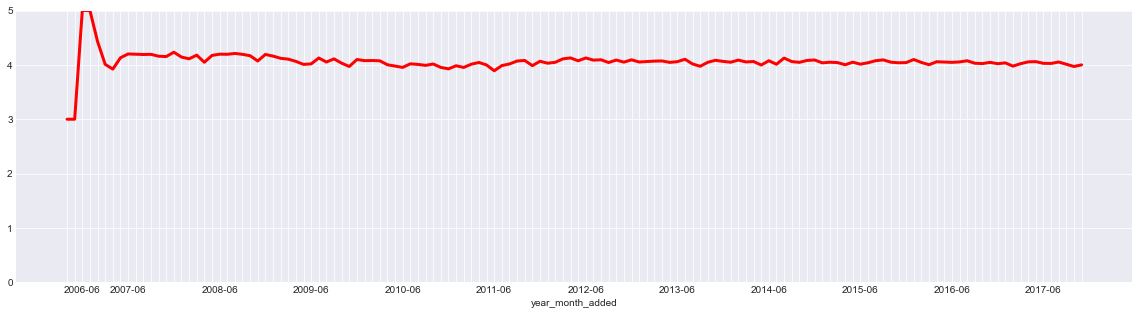

In [26]:
visualize_mean_rating_by_month(rated_df, 'year_month_added')

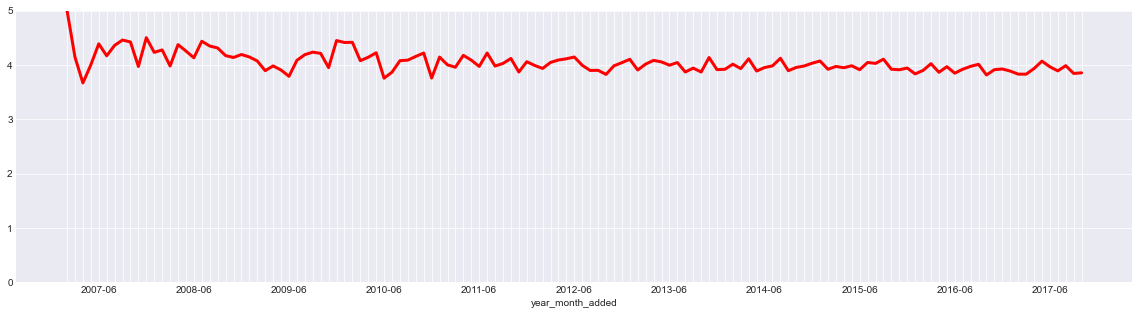

In [27]:
visualize_mean_rating_by_month(reviews_df, 'year_month_added')

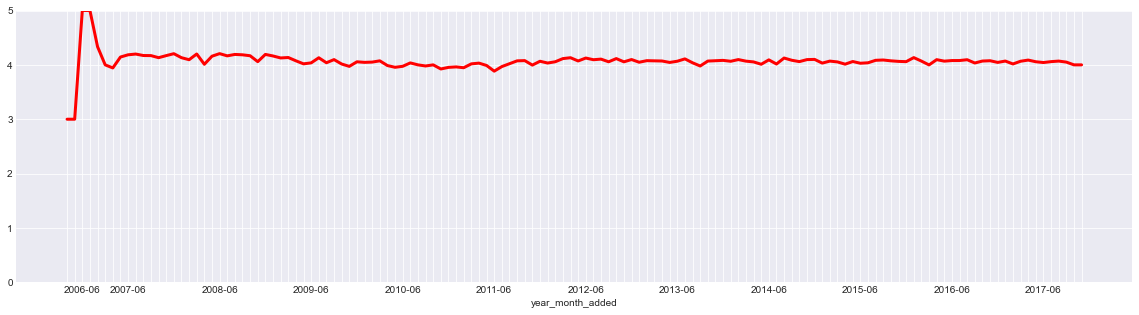

In [28]:
visualize_mean_rating_by_month(non_reviews_df, 'year_month_added')

### Rating by Date Updated

Visualizing average rating by date updated across the 3 datasets

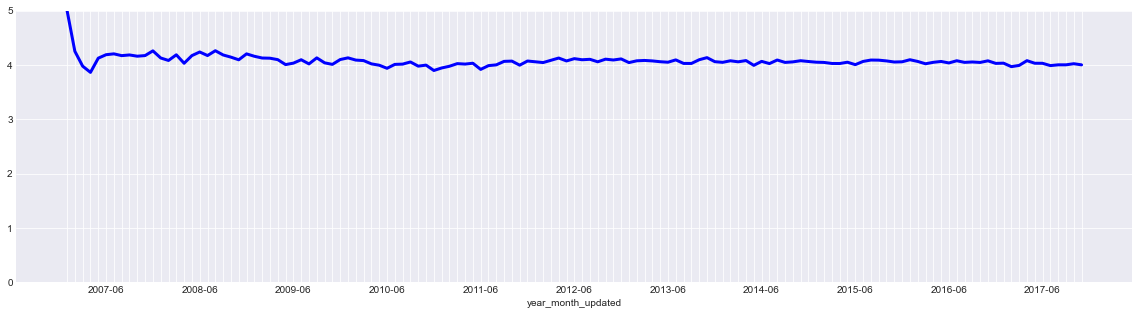

In [29]:
visualize_mean_rating_by_month(rated_df, 'year_month_updated', color='blue')

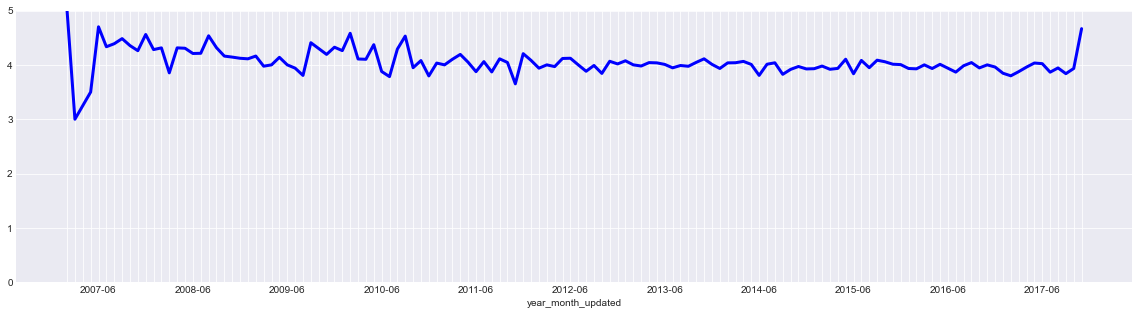

In [30]:
visualize_mean_rating_by_month(reviews_df, 'year_month_updated', color='blue')

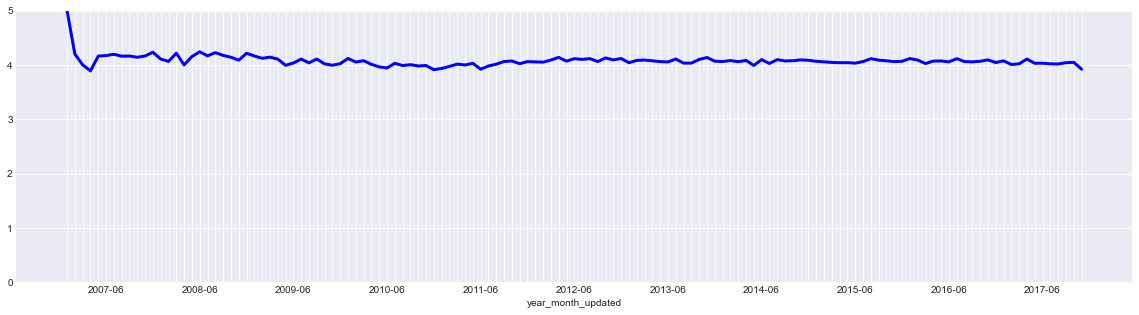

In [31]:
visualize_mean_rating_by_month(non_reviews_df, 'year_month_updated', color='blue')

### Rating by Publication Date

Visualizing average rating by publication date across the 3 datasets

In [32]:
def visualize_mean_rating_by_pub_date(data_df):
    """Visualizes the average rating in `data_df` by publication date.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas dataframe containing the data to be visualized.
    
    Returns
    -------
    None
    
    """
    grouped_date = data_df.groupby(data_df['pub_date'])['rating'].mean()
    tick_labels = [x if x[-4:] == '5-06' else '' for x in grouped_date.index]
    
    plt.figure(figsize=(20,5))
    grouped_date.plot(color='orange', linewidth=3)
    plt.xticks(range(len(tick_labels)), tick_labels)
    plt.ylim(0, 5)
    plt.show()

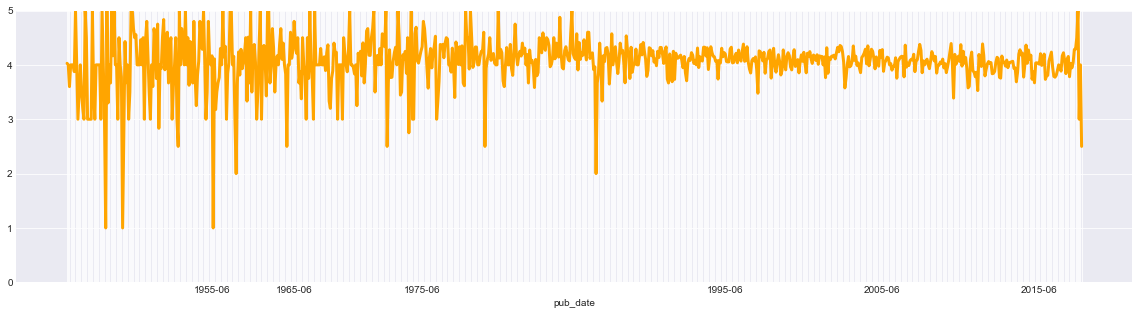

In [33]:
visualize_mean_rating_by_pub_date(rated_df)

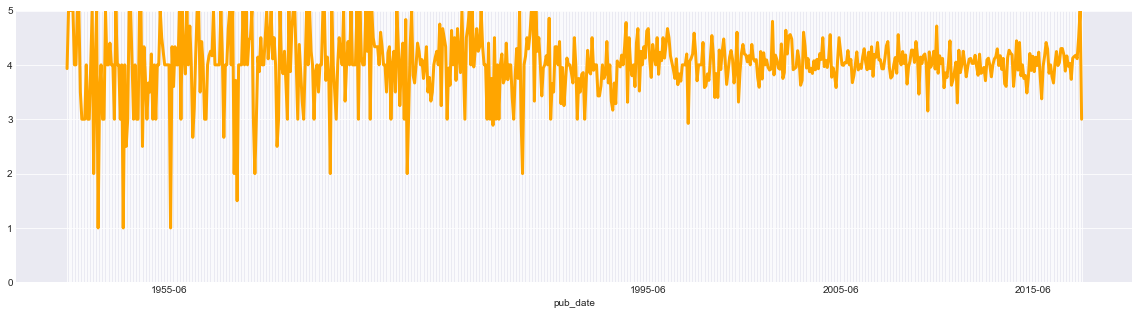

In [34]:
visualize_mean_rating_by_pub_date(reviews_df)

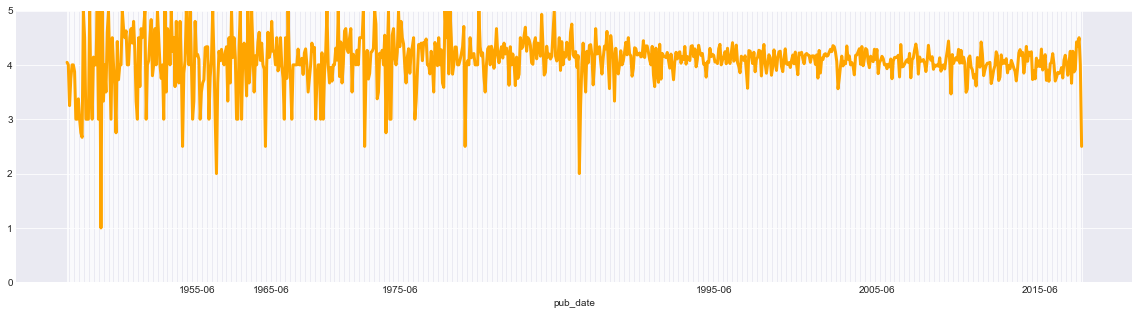

In [35]:
visualize_mean_rating_by_pub_date(non_reviews_df)

Already it is evident that rating differ depending on whether the user left a review or not.

Looking at average rating based on whether the user read the book

In [36]:
rated_df.groupby(rated_df['is_read'])['rating'].mean()

is_read
True    4.057751
Name: rating, dtype: float64

In [37]:
rated_df[rated_df['is_read'] == False]['rating'].unique()

array([], dtype=int64)

Confirms the intuition in the [Monotonic Behaviour Chains](http://cseweb.ucsd.edu/~jmcauley/pdfs/recsys18b.pdf) paper that users do not rate unless they have read first

Looking at the various stages in the interactions dataset

In [14]:
def construct_counts_df(data_df):
    """Counts the number of interactions at various stages.
    
    That is, it counts the number of records in `data_df` at
    the different stages of shelved, read, rated, reviewed.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The DataFrame for which the counts are calculated.
    
    Returns
    -------
    pd.DataFrame
        A DataFrame containing counts for each stage.
    
    """
    shelved = len(data_df)
    read = len(data_df[data_df['is_read'] == True])
    rated = len(data_df[data_df['rating'] > 0])
    recommended = len(data_df[data_df['rating'] > 3])
    counts_df = pd.DataFrame([shelved, read, rated, recommended], index=['shelved', 'read', 'rated', 'recommended'], columns=['count'])
    counts_df['percent'] = counts_df['count'] / shelved
    counts_df['percent'] = counts_df['percent'].apply(lambda x: "{}%".format(round(x*100, 2)))
    return counts_df

In [15]:
construct_counts_df(master_df)

,count,percent
shelved,273435,100.0%
read,131552,48.11%
rated,123098,45.02%
recommended,90660,33.16%


Looking at ratings across different books

In [46]:
grouped_books = rated_df.groupby(rated_df['book_id'])['rating'].mean()

In [47]:
rated_df['ratings_count'] = rated_df['ratings_count'].apply(lambda x: int(x))
rating_counts = rated_df.groupby(rated_df['book_id'])['ratings_count'].min()

<ipython-input-47-a1354781f24c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated_df['ratings_count'] = rated_df['ratings_count'].apply(lambda x: int(x))


In [48]:
rating_counts = rating_counts[rating_counts > 0].sort_values()
least_rated = rating_counts[:500].index
most_rated = rating_counts[-500:].index

books_least_rated = grouped_books[grouped_books.index.isin(least_rated)]
books_most_rated = grouped_books[grouped_books.index.isin(most_rated)]

In [49]:
def visualize_grouped_ratings(grouped_ratings, color='green'):
    """Creates a visual of the ratings in `grouped_ratings`.
    
    Assumes `grouped_ratings` is sorted in ascending order of the
    number of ratings. Thegroups could be books or users. And records
    at the start of the list correspond to groups that have fewer
    associated ratings.
    
    Parameters
    ----------
    grouped_ratings: np.array
        An numpy array of average ratings by group.
    color: str
        The color used for the line in the plot. The
        default is 'green'
    
    Returns
    -------
    None
    
    """
    tick_labels = [str(i) if i % 20 == 10 else '' for i in range(len(grouped_ratings))]
    
    plt.figure(figsize=(20,5))
    grouped_ratings.plot(color=color, linewidth=3)
    plt.xticks(range(len(grouped_ratings)), tick_labels)
    plt.ylim(0, 5)
    plt.show()

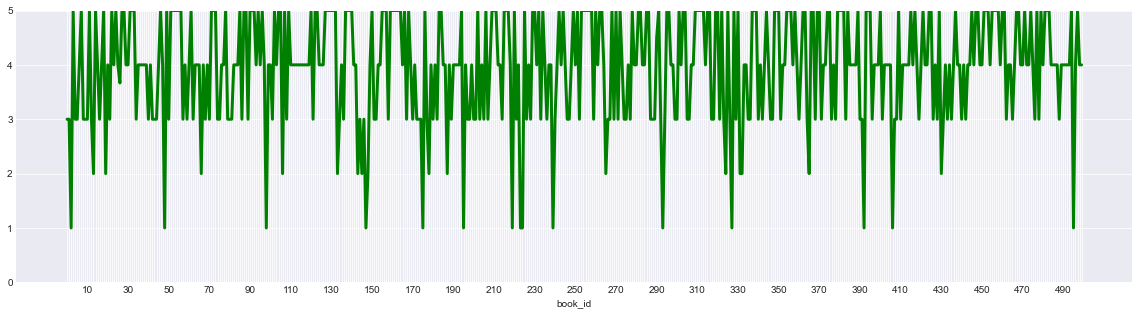

In [50]:
visualize_grouped_ratings(books_least_rated)

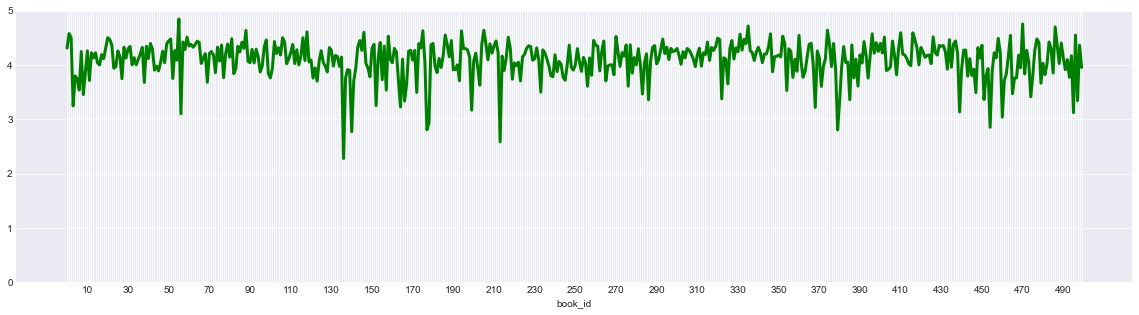

In [51]:
visualize_grouped_ratings(books_most_rated)

There seems to be no real pattern for the least rated books. However, for the most rated books the ratings seem to almost always be 3 or higher

Looking at ratings across different users

In [52]:
grouped_users = rated_df.groupby(rated_df['user_id'])['rating'].mean()

In [53]:
grouped_user_count = rated_df.groupby(rated_df['user_id'])['rating'].count()
grouped_user_count = grouped_user_count.sort_values()

infrequent_raters = grouped_user_count[:500].index
frequent_raters = grouped_user_count[-500:].index

infrequent_rater_ratings = grouped_users[grouped_users.index.isin(infrequent_raters)]
frequent_rater_ratings = grouped_users[grouped_users.index.isin(frequent_raters)]

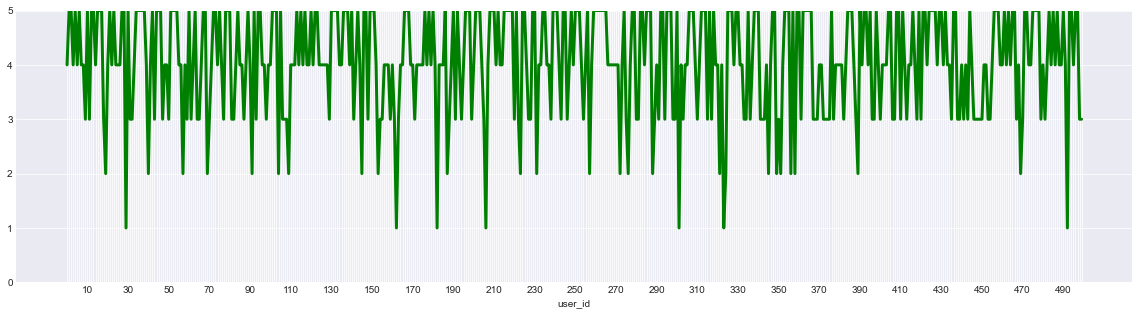

In [54]:
visualize_grouped_ratings(infrequent_rater_ratings)

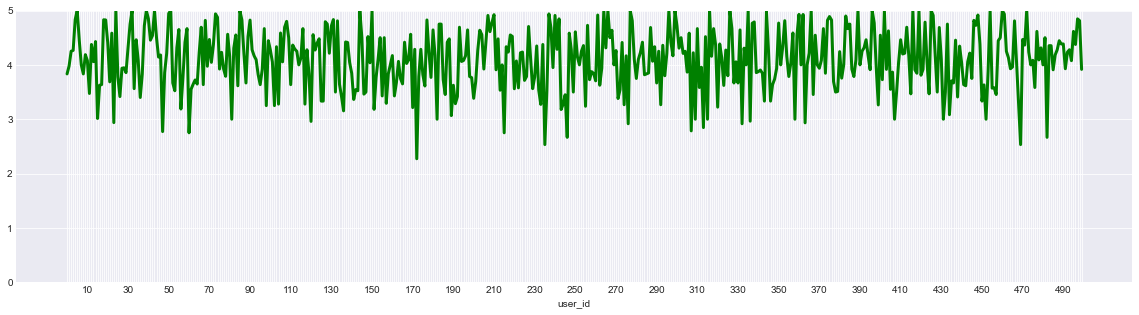

In [55]:
visualize_grouped_ratings(frequent_rater_ratings)

This is the same story as for books. Although it seems that there is more variance in average rating for the frequent raters as opposed to the average rating for frequently rated results